In [10]:
!pip3 install pygraphviz

In [11]:
import pygraphviz as pgv
from IPython.core.display import Image

In [12]:
import requests
 
ensembl_server = 'http://rest.ensembl.org'

def do_request(server, service, *args, **kwargs):
    params = ''
    for a in args:
        if a is not None:
            params += '/' + a
    req = requests.get('%s/%s%s' % (server, service, params),
                       params=kwargs,
                       headers={'Content-Type': 'application/json'})

    if not req.ok:
        req.raise_for_status()
    return req.json()

In [13]:
lct_id = 'ENSG00000115850'

In [14]:
refs = do_request(ensembl_server, 'xrefs/id', lct_id, external_db='GO', all_levels='1')

print(len(refs))
print(refs[0].keys())

for ref in refs:
    go_id = ref['primary_id']
    details = do_request(ensembl_server, 'ontology/id', go_id)
    print('%s %s %s' % (go_id,  details['namespace'], ref['description']))
    print('%s\n' % details['definition'])

26
dict_keys(['primary_id', 'display_id', 'synonyms', 'description', 'db_display_name', 'dbname', 'linkage_types', 'info_type', 'version', 'info_text'])
GO:0000016 molecular_function lactase activity
Catalysis of the reaction: lactose + H2O = D-glucose + D-galactose.

GO:0000016 molecular_function lactase activity
Catalysis of the reaction: lactose + H2O = D-glucose + D-galactose.

GO:0000016 molecular_function lactase activity
Catalysis of the reaction: lactose + H2O = D-glucose + D-galactose.

GO:0003824 molecular_function catalytic activity
Catalysis of a biochemical reaction at physiological temperatures. In biologically catalyzed reactions, the reactants are known as substrates, and the catalysts are naturally occurring macromolecular substances known as enzymes. Enzymes possess specific binding sites for substrates, and are usually composed wholly or largely of protein, but RNA that has catalytic activity (ribozyme) is often also regarded as enzymatic.

GO:0004553 molecular_funct

In [15]:
go_id = 'GO:0000016'
my_data = do_request(ensembl_server, 'ontology/id', go_id)

for k, v in my_data.items():
    if k == 'parents':
        for parent in v:
            print(parent)
            parent_id = parent['accession']
    else:
        print('%s: %s' % (k, str(v)))
        
print()
parent_data = do_request(ensembl_server, 'ontology/id', parent_id)
print(parent_id, len(parent_data['children']))

{'name': 'hydrolase activity, hydrolyzing O-glycosyl compounds', 'subsets': [], 'accession': 'GO:0004553', 'synonyms': ['O-glucosyl hydrolase activity'], 'namespace': 'molecular_function', 'ontology': 'GO', 'definition': 'Catalysis of the hydrolysis of any O-glycosyl bond.'}
children: []
definition: Catalysis of the reaction: lactose + H2O = D-glucose + D-galactose.
ontology: GO
name: lactase activity
accession: GO:0000016
subsets: []
synonyms: ['lactose galactohydrolase activity']
namespace: molecular_function

GO:0004553 127


In [16]:
refs = do_request(ensembl_server, 'ontology/ancestors/chart', go_id)

for go, entry in refs.items():
    print(go)
    term = entry['term']
    print('%s %s' % (term['name'], term['definition']))
    is_a = entry.get('is_a', [])
    print('\t is a: %s\n' % ', '.join([x['accession'] for x in is_a]))

GO:0003674
molecular_function A molecular process that can be carried out by the action of a single macromolecular machine, usually via direct physical interactions with other molecular entities. Function in this sense denotes an action, or activity, that a gene product (or a complex) performs. These actions are described from two distinct but related perspectives: (1) biochemical activity, and (2) role as a component in a larger system/process.
	 is a: 

GO:0016787
hydrolase activity Catalysis of the hydrolysis of various bonds, e.g. C-O, C-N, C-C, phosphoric anhydride bonds, etc. Hydrolase is the systematic name for any enzyme of EC class 3.
	 is a: GO:0003824

GO:0016798
hydrolase activity, acting on glycosyl bonds Catalysis of the hydrolysis of any glycosyl bond.
	 is a: GO:0016787

GO:0000016
lactase activity Catalysis of the reaction: lactose + H2O = D-glucose + D-galactose.
	 is a: GO:0004553

GO:0003824
catalytic activity Catalysis of a biochemical reaction at physiological tem

In [17]:
def get_upper(go_id):
    parents = {}
    node_data = {}
    refs = do_request(ensembl_server, 'ontology/ancestors/chart', go_id)
    for ref, entry in refs.items():
        my_data = do_request(ensembl_server, 'ontology/id', ref)
        node_data[ref] = {'name': entry['term']['name'], 'children': my_data['children']}
        try:
            parents[ref] = [x['accession'] for x in entry['is_a']]
        except KeyError:
            pass  # Top of hierarchy
    return parents, node_data

In [18]:
parents, node_data = get_upper(go_id)

strict digraph "" {
	"hydrolase activity
acting on glycosyl bonds
(GO:0016798)" -> "...2...";
	"hydrolase activity
acting on glycosyl bonds
(GO:0016798)" -> "hydrolase activity
hydrolyzing O-glycosyl compounds
(GO:0004553)";
	"hydrolase activity
hydrolyzing O-glycosyl compounds
(GO:0004553)" -> "...126...";
	"hydrolase activity
hydrolyzing O-glycosyl compounds
(GO:0004553)" -> "lactase activity
(GO:0000016)";
	"molecular_function
(GO:0003674)" -> "...20...";
	"molecular_function
(GO:0003674)" -> "catalytic activity
(GO:0003824)";
	"catalytic activity
(GO:0003824)" -> "hydrolase activity
(GO:0016787)";
	"catalytic activity
(GO:0003824)" -> "...15...";
	"hydrolase activity
(GO:0016787)" -> "hydrolase activity
acting on glycosyl bonds
(GO:0016798)";
	"hydrolase activity
(GO:0016787)" -> "...25...";
}



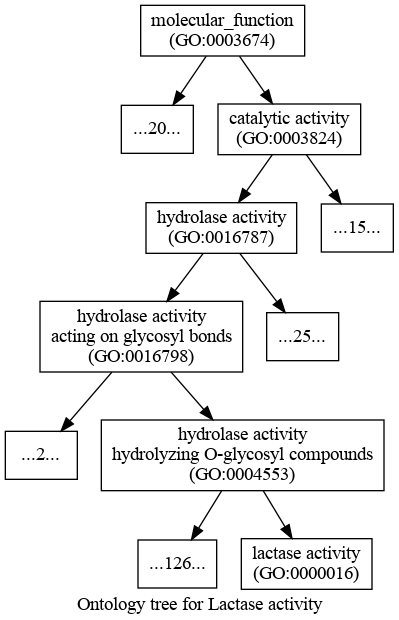

In [19]:
g = pgv.AGraph(directed=True)

for ofs, ofs_parents in parents.items():
    ofs_text = '%s\n(%s)' % (node_data[ofs]['name'].replace(', ', '\n'), ofs)
    for parent in ofs_parents:
        parent_text = '%s\n(%s)' % (node_data[parent]['name'].replace(', ', '\n'), parent)
        children = node_data[parent]['children']
        if len(children) < 3:
            for child in children:
                if child['accession'] in node_data:
                    continue
                g.add_edge(parent_text, child['accession'])
        else:
            g.add_edge(parent_text, '...%d...' % (len(children) - 1))
        g.add_edge(parent_text, ofs_text)
print(g)

g.graph_attr['label']='Ontology tree for Lactase activity'
g.node_attr['shape']='rectangle'
g.layout(prog='dot')
g.draw('graph.png')

Image("graph.png")